In [55]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import math
import torch
import unicodedata
import PLEARN_phono_helper
import imp
import glob
import os
from joblib import Parallel, delayed
imp.reload(PLEARN_phono_helper)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<module 'PLEARN_phono_helper' from '/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py'>

In [2]:
xml_path =  '/shared_hd0/corpora/phonbank/Providence/Alex/020326.xml'

test = PLEARN_phono_helper.getArticulationProp(xml_path)

Processing /shared_hd0/corpora/phonbank/Providence/Alex/020326.xml...


/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  citation_form_requires['actual_form_sz'] = [check_art(x,'actual') for x in citation_form_requires.actual]
/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  citation_form_requires['age'] = getAgeFromDatestr(root.find(".//*[@id='CHI']/age").text ,'bmw')
/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:142: SettingWithCopyWarnin

In [3]:
test.head()

,actual,model,word_gloss,preceding_gloss,spk,gloss,transcribed_model_length_mismatch,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,ˈkɑːs,ˈkɑɹz,cars,[],CHI,cars yyy,False,3,True,True,850.0,Alex,020326.xml
0,ˈpʌlɪ,ˈpliːz,please,[],CHI,please,False,15,True,False,850.0,Alex,020326.xml
0,ˈpʰlɪs,ˈpliːz,please,[],CHI,please,False,16,True,True,850.0,Alex,020326.xml
0,pəˈlis,ˈpliːz,please,[],CHI,please,False,22,True,True,850.0,Alex,020326.xml
0,ˈplis,ˈpliːz,please,[],CHI,please,False,29,True,True,850.0,Alex,020326.xml


In [4]:
transcript_paths = []
# excluding ComptonPater b/c diary study doesn't have tokens
# excluding StanfordEnglish b/c ages are not in an interpretable format
for corpus in ['Providence']:    
    transcript_paths.append(glob.glob('/shared_hd0/corpora/phonbank/'+corpus+'/**/*.xml'))
transcript_paths = [item for sublist in transcript_paths for item in sublist]
len(transcript_paths)

364

In [6]:
transcript_paths[1:5]

['/shared_hd0/corpora/phonbank/Providence/Alex/010614.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/010512.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/020300.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/030200.xml']

In [9]:
# process the phonemic transcripts and save them to a pickle

regenerate = True
parallel = True

imp.reload(PLEARN_phono_helper)
if regenerate:
    if parallel:
        phono_token_dfs = Parallel(n_jobs=os.cpu_count())(delayed(PLEARN_phono_helper.getArticulationProp)(x) for x in transcript_paths)
    else:
        phono_token_dfs = [PLEARN_phono_helper.getArticulationProp(x) for x in transcript_paths]
    phono_token_df = pd.concat([x for x in phono_token_dfs if x is not None])
    phono_token_df.to_pickle('pkl/providence_phono.pkl')
else:
    phono_token_df = pd.read_pickle('pkl/providence_phono.pkl')

In [10]:
phono_token_df.shape

(47844, 13)

In [11]:
phono_token_df.iloc[0]

actual                                     ˈkik
model                                     ˈsɪks
word_gloss                                  six
preceding_gloss                              []
spk                                         CHI
gloss                                       six
transcribed_model_length_mismatch         False
utt_index                                   143
citation_form_requires                     True
actual_form_sz                                0
age                                         677
child                                      Alex
xml_path                             011006.xml
Name: 0, dtype: object

In [12]:
counts_and_means = phono_token_df.groupby(['child','age']).actual_form_sz.aggregate( \
{'p_articulation':np.mean, 'num_tokens':np.size}).reset_index()
counts_and_means['age_in_months'] = counts_and_means['age'] / 30.5
%R -i counts_and_means

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [13]:
%%R
total_counts = aggregate(num_tokens ~ child, counts_and_means, sum)
names(total_counts) = c('child','child_num_tokens') 
print(total_counts)
print(sum(total_counts$child_num_tokens))
counts_and_means = merge(counts_and_means, total_counts)
counts_and_means$child_label = paste(counts_and_means$child, ' (n =', format(
    counts_and_means$child_num_tokens, big.mark=','), ')', sep='')

    child child_num_tokens
1    Alex             6726
2   Ethan             4150
3    Lily            11022
4   Naima            17648
5  Violet             4266
6 William             4032
[1] 47844


/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: `geom_smooth()` using method = 'loess' and formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


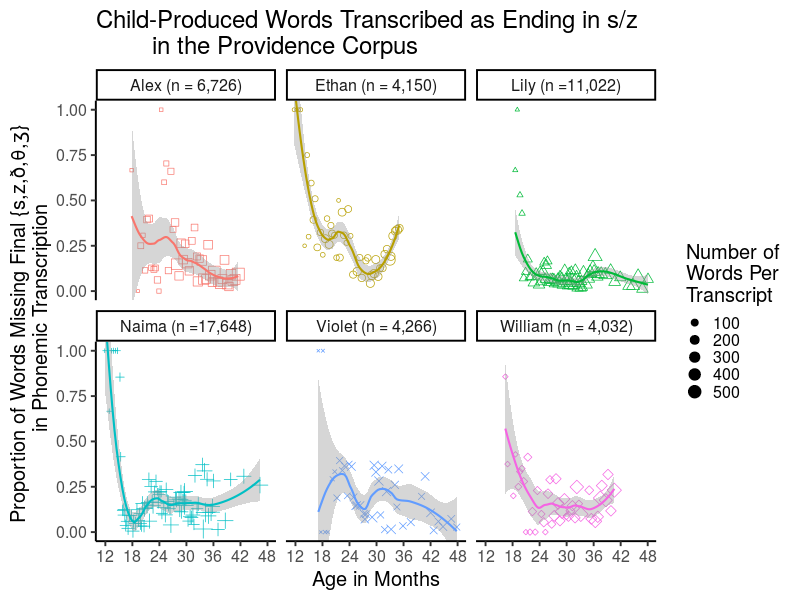

In [15]:
%%R -w 800 -h 600
p1 = ggplot(counts_and_means) + geom_point(aes(x=age_in_months, shape =child, colour=child,
y=1-p_articulation, size=num_tokens)) + scale_shape_manual(values=seq(0,15)
) + facet_wrap(~child_label) + geom_smooth(aes(x=age_in_months, y= 1-p_articulation, weight=num_tokens, colour=child),
span =1/2, show.legend = F) + coord_cartesian(ylim=c(0,1)) + ylab(
    'Proportion of Words Missing Final {s,z,ð,θ,ʒ} \n in Phonemic Transcription'
) + xlab('Age in Months') + theme_classic(base_size=20) + scale_x_continuous(breaks=seq(
    from=12, to=48, by=6)) + ggtitle('Child-Produced Words Transcribed as Ending in s/z 
\tin the Providence Corpus') + guides(colour=F, shape=F) + labs(size = "Number of\nWords Per\nTranscript")

ggsave('figures/elision_prevalence.png')
ggsave('figures/elision_prevalence.pdf')
print(p1)

In [16]:
phono_token_df.loc[(phono_token_df.child =='Naima') & (phono_token_df.age > 1250)]

,actual,model,word_gloss,preceding_gloss,spk,gloss,transcribed_model_length_mismatch,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,ˈdeɪθk,ˈdædiːz,Daddy's,[],CHI,Daddy's gonna give me the yyy and you be the s...,False,2,True,1.0,1413.0,Naima,031010.xml
12,ˈpli,ˈpliːz,please,"[Daddy's, gonna, give, me, the, yyy, and, you,...",CHI,Daddy's gonna give me the yyy and you be the s...,False,2,True,0.0,1413.0,Naima,031010.xml
2,ˈðɪθ,ˈðɪs,this,"[no, like]",CHI,no like this,False,26,True,1.0,1413.0,Naima,031010.xml
1,ˈdæɪð,ˈdædiːz,Daddy's,[no],CHI,no Daddy's gonna be the customer and you're go...,False,38,True,1.0,1413.0,Naima,031010.xml
2,ˈθɪð,ˈθɪŋz,things,"[give, me]",CHI,give me things that we don't want,False,40,True,1.0,1413.0,Naima,031010.xml
1,ˈɡʊð,ˈɡoʊz,goes,[it],CHI,it goes to the receipt roll,False,47,True,1.0,1413.0,Naima,031010.xml
0,ˈjɛs,ˈjɛs,yes,[],CHI,yes we can,False,59,True,1.0,1413.0,Naima,031010.xml
3,ˈðis,ˈðɪs,this,"[you, can, pull]",CHI,you can pull this way,False,61,True,1.0,1413.0,Naima,031010.xml
0,ˈðɪs,ˈðɪs,this,[],CHI,this way,False,66,True,1.0,1413.0,Naima,031010.xml
1,ˈðʊθ,ˈðɪs,this,[no],CHI,no this way,False,68,True,1.0,1413.0,Naima,031010.xml


In [17]:
# Ethan over 925
phono_token_df.loc[(phono_token_df.child =='Ethan') & (phono_token_df.age > 925)]

,actual,model,word_gloss,preceding_gloss,spk,gloss,transcribed_model_length_mismatch,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
1,ˈiðduwɪnə,ˈhiːz,he's,[yyy],CHI,yyy he's doing a yyy yyy yyy,False,33,True,1.0,1026.0,Ethan,020920.xml
1,ˈɪð,ˈɪz,is,[one],CHI,one is a<n> airplane one is helicopter,False,47,True,1.0,1026.0,Ethan,020920.xml
5,ðɪ,ˈɪz,is,"[one, is, a<n>, airplane, one]",CHI,one is a<n> airplane one is helicopter,False,47,True,0.0,1026.0,Ethan,020920.xml
0,ˈdæs,ˈðæts,that's,[],CHI,that's a good name,False,61,True,1.0,1026.0,Ethan,020920.xml
0,ˈðætʰ,ˈðæts,that's,[],CHI,that's the red and blue one,False,74,True,1.0,1026.0,Ethan,020920.xml
2,ˈbuf,ˈboʊθ,both,"[they, did]",CHI,they did both,False,89,True,0.0,1026.0,Ethan,020920.xml
1,ˈbofə,ˈboʊθ,both,[yyy],CHI,yyy both but he has no wings,False,91,True,0.0,1026.0,Ethan,020920.xml
4,hæz,ˈhæz,has,"[yyy, both, but, he]",CHI,yyy both but he has no wings,False,91,True,1.0,1026.0,Ethan,020920.xml
6,nwɪ,ˈwɪŋz,wings,"[yyy, both, but, he, has, no]",CHI,yyy both but he has no wings,False,91,True,0.0,1026.0,Ethan,020920.xml
2,ˈdʌz,ˈdʌz,does,"[but, he]",CHI,but he does have wings,False,94,True,1.0,1026.0,Ethan,020920.xml


/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: `geom_smooth()` using method = 'loess' and formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


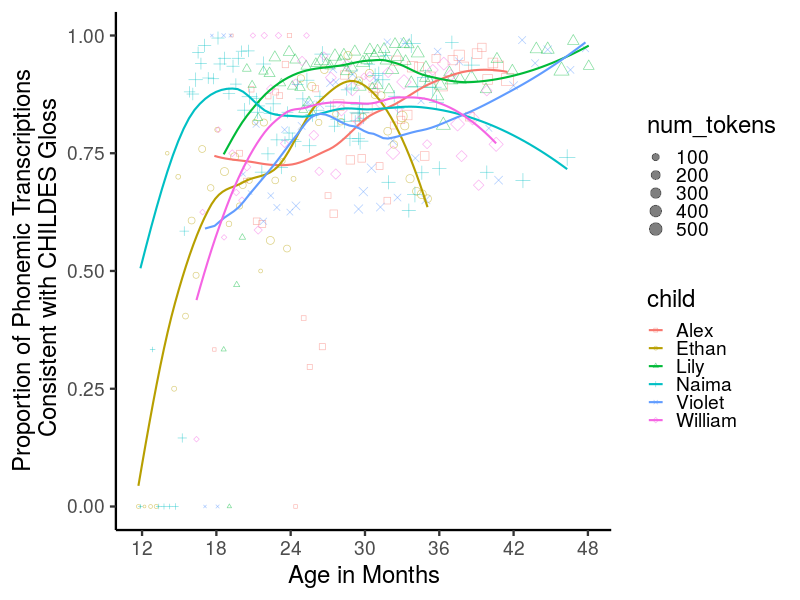

In [18]:
%%R -w 800 -h 600
ggplot(counts_and_means) + geom_point(aes(x=age_in_months, 
y=p_articulation, colour=child, shape=child, size=num_tokens), alpha =.5
) +  scale_shape_manual(values=seq(0,15))  + geom_smooth(aes(x=age_in_months, y= p_articulation,
weight=num_tokens, colour=child), se=F,
span =2/3) + coord_cartesian(ylim=c(0,1)) + theme_classic(base_size =24
) + ylab('Proportion of Phonemic Transcriptions\n Consistent with CHILDES Gloss'
) + xlab('Age in Months')  + scale_x_continuous(breaks=seq(from=12, to=48, by=6))

/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 11.1 x 8.33 in image

  warnings.warn(x, RRuntimeWarning)


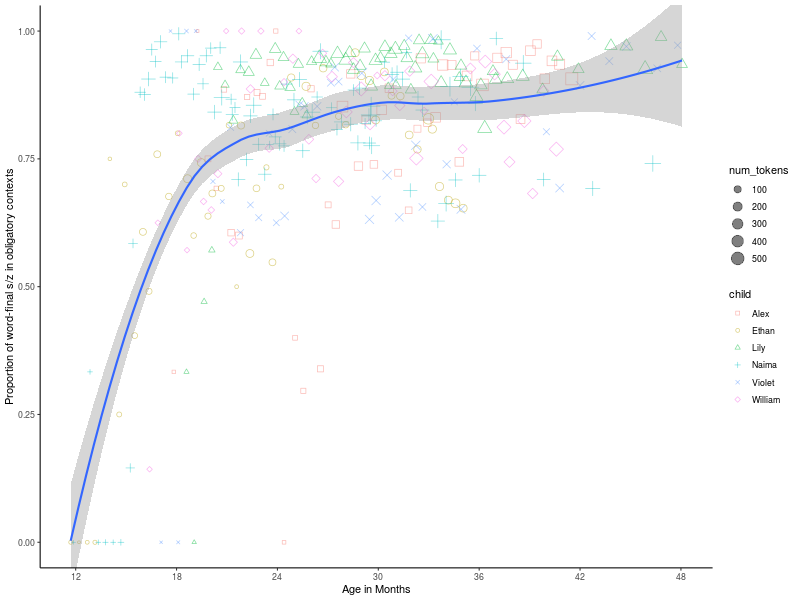

In [19]:
%%R -w 800 -h 600
p1 = ggplot(counts_and_means) + geom_point(aes(x=age_in_months, 
y=p_articulation, colour=child, shape=child, size=num_tokens), alpha =.5
)  +  scale_shape_manual(values=seq(0,15)) + geom_smooth(aes(x=age_in_months, 
y= p_articulation), se=T,span =2/3, ) + coord_cartesian(ylim=c(0,1)
) + theme_classic(
) + ylab('Proportion of word-final s/z in obligatory contexts'
) + xlab('Age in Months') + scale_x_continuous(breaks=seq(from=12, to=48, by=6))

ggsave('figures/p_articulation_across_children.pdf')

print(p1)

In [21]:
%%R
# get p_art from the above for every day, 1:365*4
query_ages_in_days = seq(0, (365*10))
query_ages_in_months = query_ages_in_days / 30.5

art.lo <- loess(p_articulation ~ age_in_months, counts_and_means,
    control = loess.control(surface = "direct"))
predicted = predict(art.lo, data.frame(age_in_months = query_ages_in_months), se = TRUE)
df = data.frame(age_in_days = query_ages_in_days, p_art = predicted$fit)
df$p_art[df$p_art < 0] = 0
write.csv(df,'csv/articulation_curve.csv', row.names=F)

# Model vs. Manual Transcriptions in Phonbank

It is not clear from the database manual, or from Song et al. 2009, what the convention was for the model-based transcription in the Providence corpus. For examples where the child uses an apparent singular form when the gloss is plural, where does this come from?

In [23]:
phono_token_df.to_csv('csv/phono_token_df.csv')

# Probability of Gloss vs. Transcript under an Adult Language Model

In [24]:
# identify instances of annotator-recovery from above 
# check if the production is in the dictionary, unk token if not

In [25]:
annotator_recovered_tokens = phono_token_df.loc[phono_token_df.actual_form_sz == 0]
annotator_recovered_tokens.shape

(6866, 13)

In [26]:
annotator_recovered_tokens.head(100)

,actual,model,word_gloss,preceding_gloss,spk,gloss,transcribed_model_length_mismatch,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,ˈkik,ˈsɪks,six,[],CHI,six,False,143,True,0.0,677.0,Alex,011006.xml
0,wə,ˈwʌts,what's,[],CHI,what's that,False,364,True,0.0,677.0,Alex,011006.xml
0,ˈɪː,ˈsɪks,six,[],CHI,six,False,394,True,0.0,677.0,Alex,011006.xml
0,kɪːk,ˈsɪks,six,[],CHI,six,False,965,True,0.0,677.0,Alex,011006.xml
0,ˈwɪ,ˈwɛɹz,where's,[],CHI,where's the red,False,189,True,0.0,824.0,Alex,020300.xml
0,ˈɪ,ˈhɪz,his,[],CHI,his shoes,False,221,True,0.0,824.0,Alex,020300.xml
0,ˈwɪ,ˈwɛɹz,where's,[],CHI,where's the black,False,275,True,0.0,824.0,Alex,020300.xml
0,ˈɛk,ˈɛks,x@l,[],CHI,x@l,False,361,True,0.0,824.0,Alex,020300.xml
0,ˈɪ,ˈlɛts,let's,[],CHI,let's see,False,581,True,0.0,824.0,Alex,020300.xml
0,ˈpiː,ˈpliːz,please,[],CHI,please,False,645,True,0.0,824.0,Alex,020300.xml


In [28]:
# Need a pronunciation dictionary. Start with https://github.com/menelik3/cmudict-ipa 

In [29]:
cmu_dict = pd.read_csv('/home/stephan/python/cmudict-ipa/cmudict-0.7b-ipa.txt',
    sep='\t', lineterminator='\r', header=None)
cmu_dict.columns = ['ortho','ipa']

print(cmu_dict.shape)
print(cmu_dict.head(5))

(125075, 2)
                ortho                   ipa
0  !EXCLAMATION-POINT  ˌɛkskləˈmeɪʃənˌpɔɪnt
1      \n"CLOSE-QUOTE          ˈkloʊzˈkwoʊt
2     \n"DOUBLE-QUOTE          ˈdʌbəlˈkwoʊt
3     \n"END-OF-QUOTE          ˈɛndəvˈkwoʊt
4        \n"END-QUOTE            ˈɛndˈkwoʊt


In [33]:
#make this longform, clean the contents
def expand_cmu_dict(cmu_record):
    ipa_split = [clean_cmu(x) for x in str(cmu_record['ipa']).split(', ')]
    rdf = pd.DataFrame({'ipa':ipa_split})
    rdf['ortho'] = cmu_record['ortho'].replace('\n','').lower()
    return(rdf)
    
def clean_cmu(cmu_pronunciation):
    # not clearn what cleaning is necessary    
    return(unicodedata.normalize('NFC', cmu_pronunciation))

cmu_dict_long = pd.concat([expand_cmu_dict(x) for x in cmu_dict.to_dict('records')])

In [34]:
cmu_dict_long.loc[cmu_dict_long.ortho == 'juice']

,ipa,ortho
0,ˈdʒuːs,juice


In [35]:
annotator_recovered_tokens.head()

,actual,model,word_gloss,preceding_gloss,spk,gloss,transcribed_model_length_mismatch,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,ˈkik,ˈsɪks,six,[],CHI,six,False,143,True,0.0,677.0,Alex,011006.xml
0,wə,ˈwʌts,what's,[],CHI,what's that,False,364,True,0.0,677.0,Alex,011006.xml
0,ˈɪː,ˈsɪks,six,[],CHI,six,False,394,True,0.0,677.0,Alex,011006.xml
0,kɪːk,ˈsɪks,six,[],CHI,six,False,965,True,0.0,677.0,Alex,011006.xml
0,ˈwɪ,ˈwɛɹz,where's,[],CHI,where's the red,False,189,True,0.0,824.0,Alex,020300.xml


In [36]:
cmu_dict_long['ipa']

0    ˌɛkskləˈmeɪʃənˌpɔɪnt
0            ˈkloʊzˈkwoʊt
0            ˈdʌbəlˈkwoʊt
0            ˈɛndəvˈkwoʊt
0              ˈɛndˈkwoʊt
0              ˈɪnˈkwoʊts
0                  ˈkwoʊt
0               ˈʌnˈkwoʊt
0               ˈhæˌmɑːrk
0             ˈpaʊndˌsaɪn
0             ˈʃɑːrpˌsaɪn
0                 pɝˈsɛnt
0              ˈæmpɝˌsænd
0                 ˌɑːˈloʊ
0             əˈpɑːstrəfi
0                   ˈbaʊt
0                     kəz
0                   ˈkɔrs
0                  ˈkjuːz
0                      əm
0          ˈɛnˈdɪnɝˈkwoʊt
0              ˈɛndˈkwoʊt
0                ˈfrɪskoʊ
0                    ˈgɛn
0              ˈɪnɝˈkwoʊt
0                    ˈkeɪ
0                      əm
0                      ən
0                  ˈkwoʊt
0                  ˈraʊnd
             ...         
0                zˈwiːbəl
0          zˈwiːfəlˌhɑːfɝ
0                  zˈwiːg
0                 zˈwɪlɪŋ
0              zvəˈlɪnski
0                 ˈzɪˌkæd
0                  ˈzaɪtʃ
0           

In [37]:
"ˈsɪks" in set(cmu_dict_long['ipa'])

True

In [38]:
# Need broad coverage among the model annotations
ipa_set = set(cmu_dict_long['ipa']).union(set([x.replace('r','ɹ') for x in \
    cmu_dict_long['ipa']])).union(set([x.replace('ɑː','ɑ') for x in \
    cmu_dict_long['ipa']])).union(set([x.replace('ɑː','ɑ').replace('r','ɹ') for x in \
    cmu_dict_long['ipa']]))
print(len(ipa_set))

def normalize_pvd(pvd_str):
    pvd_str = pvd_str.replace('ɡ','g') #unicode 609 latin g, damn it
    pvd_str = pvd_str.replace('ʧ','tʃ')
    pvd_str = pvd_str.replace('ʤ','dʒ')
    return(unicodedata.normalize('NFC', pvd_str))

annotator_recovered_tokens['model_normalized'] = [ normalize_pvd(x) \
    for x in annotator_recovered_tokens.model]
annotator_recovered_tokens['actual_in_cmu'] = [x in ipa_set for x in 
    annotator_recovered_tokens.model_normalized]
print(np.mean(annotator_recovered_tokens['actual_in_cmu']))

183024
0.9446548208563939


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [39]:
cmu_dict_long.loc[cmu_dict_long.ortho == "cheese"].iloc[0]

ipa      ˈtʃiːz
ortho    cheese
Name: 0, dtype: object

In [40]:
cmu_dict_long.loc[cmu_dict_long.ortho == "where's"]

,ipa,ortho
0,ˈwɛrz,where's
1,ˈhwɛrz,where's


In [41]:
[ord(x) for x in cmu_dict_long.loc[cmu_dict_long.ortho == "goes"].iloc[0].ipa]

[712, 103, 111, 650, 122]

In [42]:
cmu_dict_long.loc[cmu_dict_long.ortho == "butterflies"]

,ipa,ortho
0,ˈbʌtɝˌflaɪz,butterflies


In [45]:
annotator_recovered_tokens.loc[~annotator_recovered_tokens.actual_in_cmu].model.\
value_counts().head(10)

ˈʌɹθ             18
ˈbʌɹdz           13
ˈoʊdiˌoʊz        11
ˈkʌləɹz          10
ˈnʌɹs             9
ˈɡoʊldiːˌlɑks     9
ˈflaʊəɹz          8
ˈbʌtəɹˌflaɪz      7
ˈɑlˌweɪz          6
ˈlɛɡoʊz           6
Name: model, dtype: int64

In [46]:
annotator_recovered_tokens['alternative_candidates'] = [cmu_dict_long.loc[\
    cmu_dict_long.ipa == x].ortho for x in \
    annotator_recovered_tokens.actual]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
annotator_recovered_tokens['num_alt_candidates'] = [len(x) for x in \
    annotator_recovered_tokens['alternative_candidates']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
annotator_recovered_tokens['num_alt_candidates'].value_counts()

0     5581
1      600
2      379
5       90
3       82
4       76
6       40
7       14
10       3
8        1
Name: num_alt_candidates, dtype: int64

# Probability under GPT-2

In [56]:
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

100%|██████████| 656/656 [00:00<00:00, 270307.83B/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [57]:
art  = annotator_recovered_tokens.iloc[0:3].to_dict('records')
art

[{'actual': 'ˈkik',
  'actual_form_sz': 0.0,
  'actual_in_cmu': True,
  'age': 677.0,
  'alternative_candidates': Series([], Name: ortho, dtype: object),
  'child': 'Alex',
  'citation_form_requires': True,
  'gloss': 'six',
  'model': 'ˈsɪks',
  'model_normalized': 'ˈsɪks',
  'num_alt_candidates': 0,
  'preceding_gloss': [],
  'spk': 'CHI',
  'transcribed_model_length_mismatch': False,
  'utt_index': 143,
  'word_gloss': 'six',
  'xml_path': '011006.xml'},
 {'actual': 'wə',
  'actual_form_sz': 0.0,
  'actual_in_cmu': True,
  'age': 677.0,
  'alternative_candidates': Series([], Name: ortho, dtype: object),
  'child': 'Alex',
  'citation_form_requires': True,
  'gloss': "what's that",
  'model': 'ˈwʌts',
  'model_normalized': 'ˈwʌts',
  'num_alt_candidates': 0,
  'preceding_gloss': [],
  'spk': 'CHI',
  'transcribed_model_length_mismatch': False,
  'utt_index': 364,
  'word_gloss': "what's",
  'xml_path': '011006.xml'},
 {'actual': 'ˈɪː',
  'actual_form_sz': 0.0,
  'actual_in_cmu': True

In [58]:
def gpt_score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return loss.detach().numpy().flatten()[0]

In [59]:
print(gpt_score('two little kitty cats'))
print(gpt_score('two little kitty cat'))

6.795513
7.607923


In [64]:
# for each of the annotator_recovered_tokens
def get_p_caregiver_recovery(art, verbose=False):
    if len(art['alternative_candidates']) == 0:
        return(None)
    elif len(art['preceding_gloss']) == 0: # need to use things with a preceding context
        return(None)
    elif ('xxx' in art['preceding_gloss']) | ('yyy' in art['preceding_gloss']):
        return(None) # unknown words
    else:
        alt_candidate_scores = []
        annotator_recovery_s = ' '.join(art['preceding_gloss']+[art['word_gloss']])
        if verbose:
            print(annotator_recovery_s)
        annotator_recovery_p = gpt_score(annotator_recovery_s)
        for alt_candidate in art['alternative_candidates']:
            alt_recovery_s = ' '.join(art['preceding_gloss']+[alt_candidate])
            if verbose:
                print(alt_recovery_s)
            alt_recovery_p = gpt_score(alt_recovery_s)
            alt_candidate_scores.append(alt_recovery_p)
        
        highest_alt_recovery_p_idx = np.argmax(alt_recovery_p)
        highest_alt_recovery_p = alt_candidate_scores[highest_alt_recovery_p_idx]
        highest_alt_candidate = np.array(art['alternative_candidates'])[highest_alt_recovery_p_idx]
        rdict = {
            'annotator_recovery_p':annotator_recovery_p,
            'highest_alt_recovery_p':highest_alt_recovery_p, 
            'recovery_gloss':art['word_gloss'],
            'highest_alt_candidate':highest_alt_candidate,
            'odds_ratio': annotator_recovery_p / highest_alt_recovery_p
        }
        return(rdict)
        
p_caregiver = [get_p_caregiver_recovery(x, verbose=False) for x in \
    annotator_recovered_tokens.to_dict('records')]        
p_caregiver_df = pd.DataFrame([x for x in p_caregiver if x is not None])

In [65]:
[type(x) for x in p_caregiver_df.iloc[0]]

[numpy.float64, str, numpy.float64, numpy.float64, str]

In [66]:
%R -i p_caregiver_df

In [67]:
%R nrow(p_caregiver_df)

array([603], dtype=int32)

In [68]:
%%R
t.test(p_caregiver_df$annotator_recovery_p,
       p_caregiver_df$highest_alt_recovery_p,paired=TRUE)



	Paired t-test

data:  p_caregiver_df$annotator_recovery_p and p_caregiver_df$highest_alt_recovery_p
t = -18.531, df = 602, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.463957 -1.991751
sample estimates:
mean of the differences 
              -2.227854 



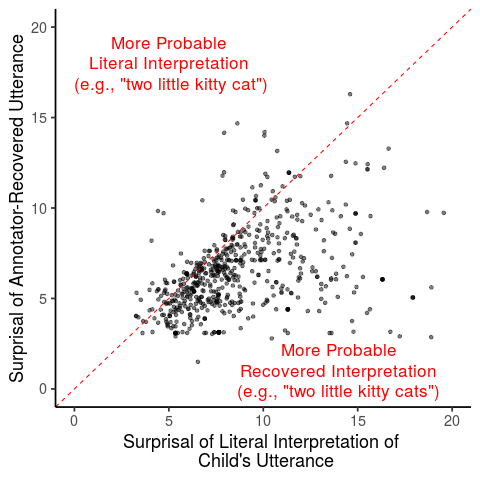

In [69]:
%%R
p1 = ggplot(p_caregiver_df) + geom_point(aes(y = annotator_recovery_p,
    x = highest_alt_recovery_p), alpha=.5) + geom_abline(y=0, slope=1, color='red', linetype='dashed'
) + coord_cartesian(xlim=c(0,20), ylim=c(0,20)) + theme_classic(base_size=18) + xlab(
"Surprisal of Literal Interpretation of \n Child's Utterance") + ylab(
'Surprisal of Annotator-Recovered Utterance') + annotate("text", x = 5, y = 18,
label = 'More Probable\nLiteral Interpretation\n (e.g., "two little kitty cat")', colour='red', size=6,
lineheight = 1) + annotate("text", 
x = 14, y = 1, label = 'More Probable\nRecovered Interpretation\n(e.g., "two little kitty cats")',
colour='red', size=6, lineheight = 1)

print(p1)
ggsave('figures/probability_under_models.png', width=6, height=6)
ggsave('figures/probability_under_models.pdf', width=6, height=6)